<a href="https://colab.research.google.com/github/naguzmans/opportunistic-atm/blob/master/01_flights_to_week_array.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Create Flights Array

The goal of this code is to create an array of shape (weeks, hours, 100, 100, 20) for training the model later.

**Lists folders containing data**

In [ ]:
import glob

# Home folder
%cd /content/drive/MyDrive/opportunistic-utm

# List of folders with data
folder_list = []
for folder in glob.iglob('dataset/**/**/', recursive=False):
  folder_list.append(folder)

folder_list[:5]

/content/drive/MyDrive/opportunistic-utm


['dataset/2019-01/2019-01-01/',
 'dataset/2019-01/2019-01-02/',
 'dataset/2019-01/2019-01-03/',
 'dataset/2019-01/2019-01-04/',
 'dataset/2019-01/2019-01-05/']

**Gets a list of each week of 7 days**

In [ ]:
import datetime
import numpy as np
import os

# Gets date from each folder and appends each Monday of a date to a list
# The goal is to get the number of weeks present in the list
monday_list = []
for folder in folder_list:
  folder_date = os.path.basename(os.path.normpath(folder))
  date = datetime.datetime.strptime(folder_date, '%Y-%m-%d')
  monday_date = date - datetime.timedelta(days=date.weekday())
  monday_list.append(monday_date)

# Filters the list by unique monday values and complete weeks of 7 days
monday_list = np.unique(np.array(monday_list), return_counts=True)
filter = np.where(monday_list[1] == 7, True, False)
monday_list = monday_list[0][filter].tolist()

**Extracts the data from full 7-day weeks**

In [ ]:
from tqdm import tqdm

# Data array is created by looping each Monday through 7 days of the week
index = 0
week_array = []

# Iterates through Monday list
for monday in tqdm(monday_list):
  hours_array = np.empty((1,100,100,20))
  
  # Iterates over 7 days of that Monday week
  for day in range(7):
    day_date = monday + datetime.timedelta(days=day)
    day_str = day_date.strftime('%Y-%m-%d')
    month_str = day_date.strftime('%Y-%m')
    files = np.sort(glob.glob(f'dataset/{month_str}/{day_str}/*.npy', recursive=False))
    
    # Iterates over 24 hours of every day
    for i in range(0, 24):
      next_hour = np.expand_dims(np.moveaxis(np.load(files[i]), 0, -1), 0)
      hours_array = np.concatenate((hours_array, next_hour), axis=0)
  week_array.append(hours_array[1:])

# Transforms to Numpy array
week_array = np.array(week_array)
week_array.shape

100%|██████████| 38/38 [50:00<00:00, 78.97s/it]


(38, 168, 100, 100, 20)

# Visualization

In [ ]:
# Flattens multichannel array
def flatten_array(input_array):
  len_array = input_array.shape[-1]
  levels_array = []
  for i in range(0, len_array):
    level = input_array[:, :, i]*((i+1)/len_array)
    levels_array.append(level)
  
  levels_array = np.array(levels_array)
  levels_array = np.moveaxis(levels_array, 0, -1)

  return np.amax(levels_array, axis=2)

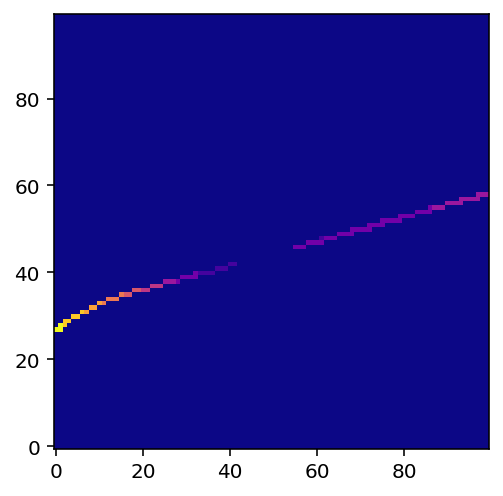

In [ ]:
# Previews single image
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

flatten = flatten_array(week_array[0,0])
plt.imshow(flatten, origin='lower', cmap = plt.get_cmap('plasma'))

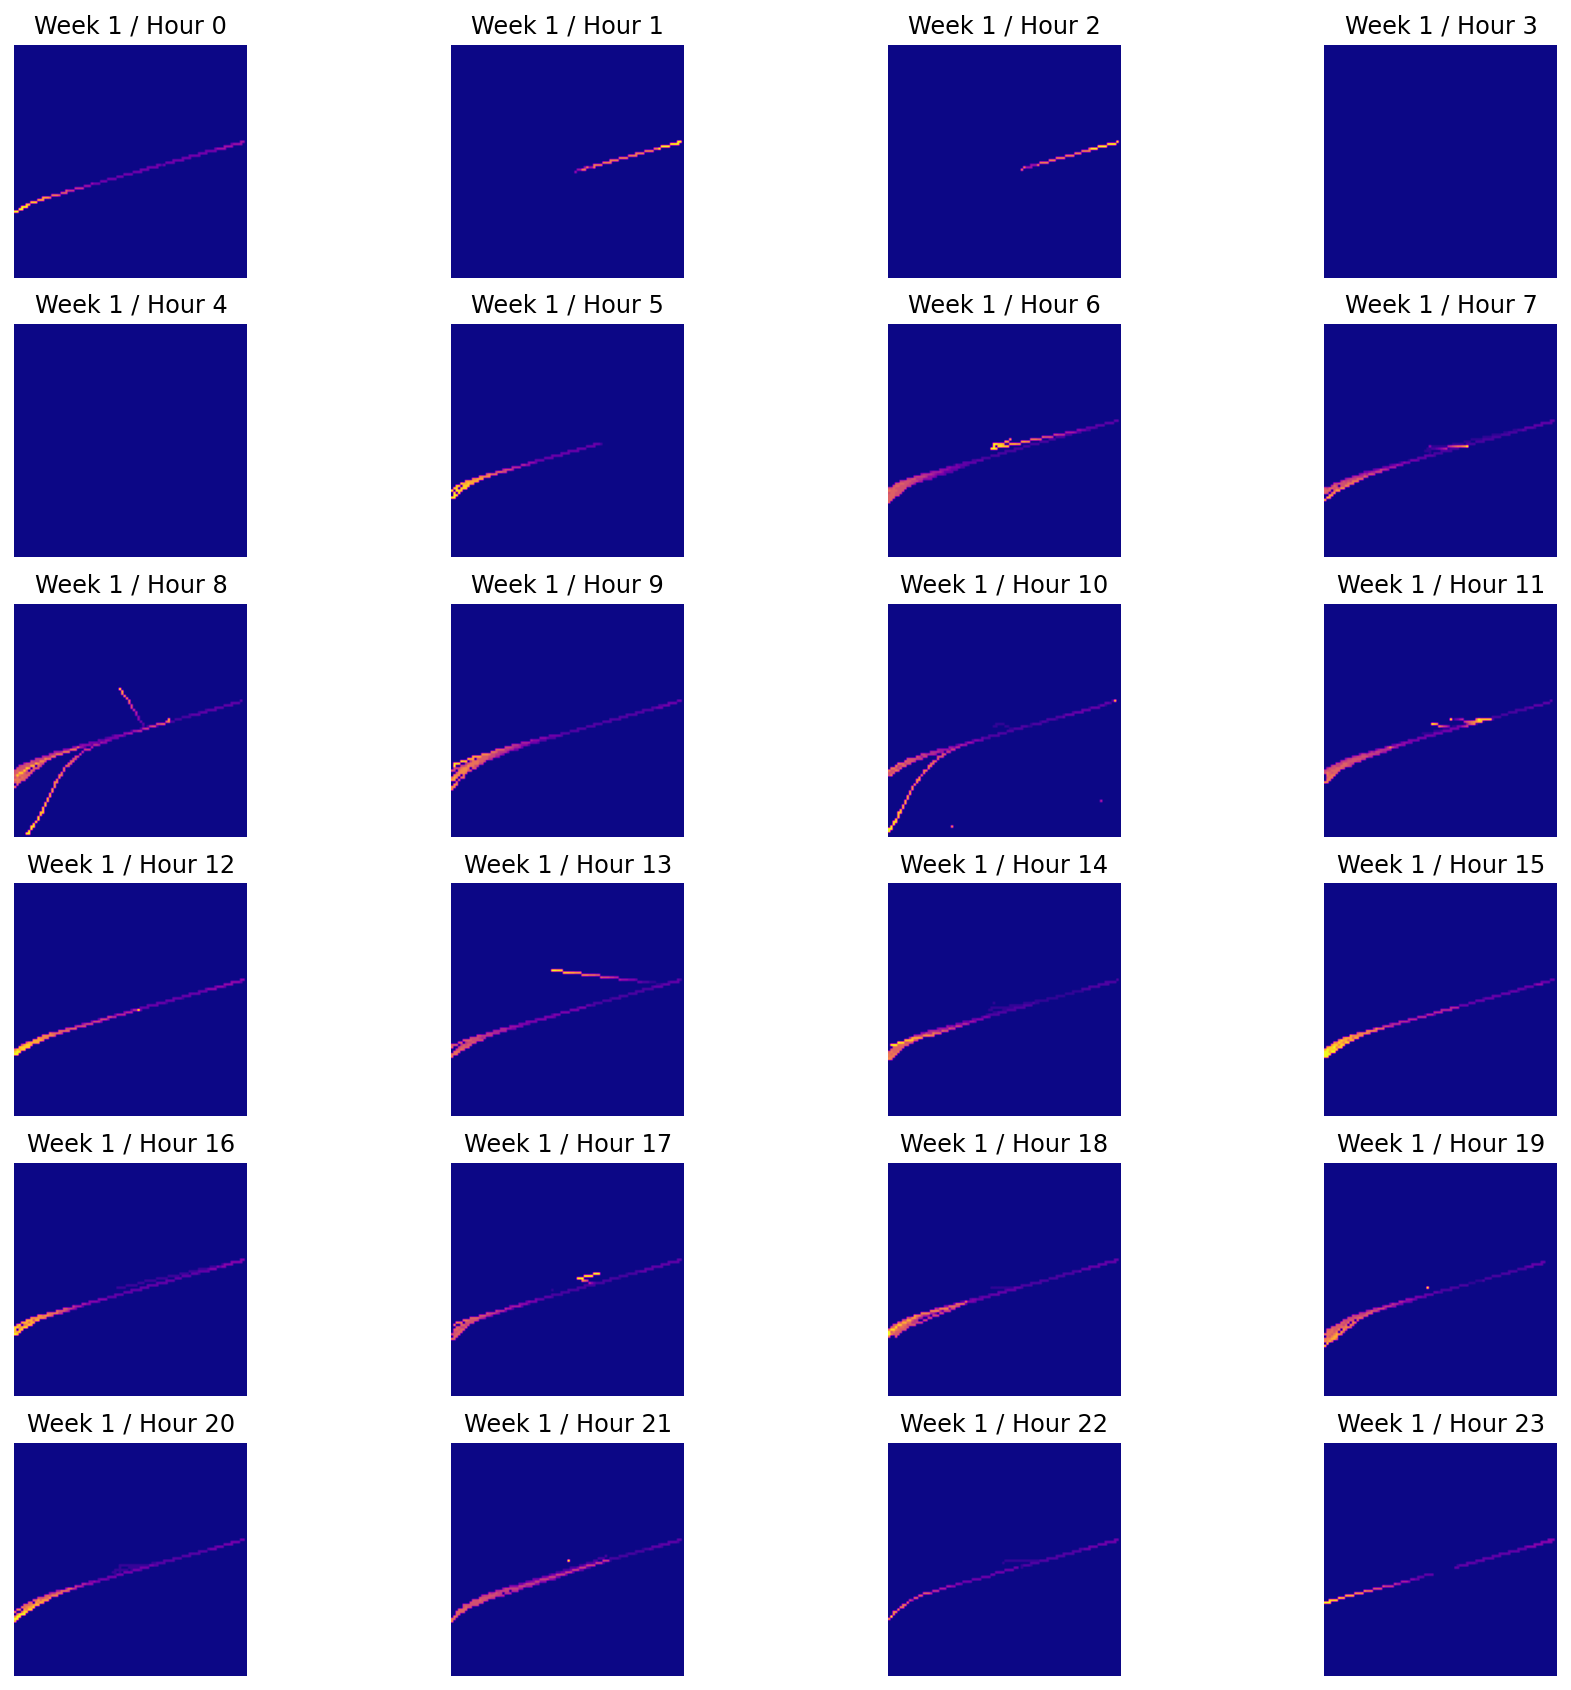

In [ ]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

week = 1 # Week since dataset started
day = 0 # 0 to 6 / Mon to Sun

# Previews a whole day
fig, ax = plt.subplots(6, 4, figsize=(15, 15))
for idx, ax in enumerate(ax.flat):
  plot = ax.imshow(flatten_array(week_array[week, idx + (day * 24)]), origin='lower', cmap = plt.get_cmap('plasma'))
  ax.set_title(f'Week {week} / Hour {idx + (day * 24)}')
  ax.axis("off")

# Calculate Flights Envelope

Level 0: 131
Level 1: 186
Level 2: 164
Level 3: 171
Level 4: 172
Level 5: 192
Level 6: 196
Level 7: 197
Level 8: 194
Level 9: 177
Level 10: 158
Level 11: 104
Level 12: 52
Level 13: 1
Level 14: 0
Level 15: 0
Level 16: 0
Level 17: 0
Level 18: 0
Level 19: 0


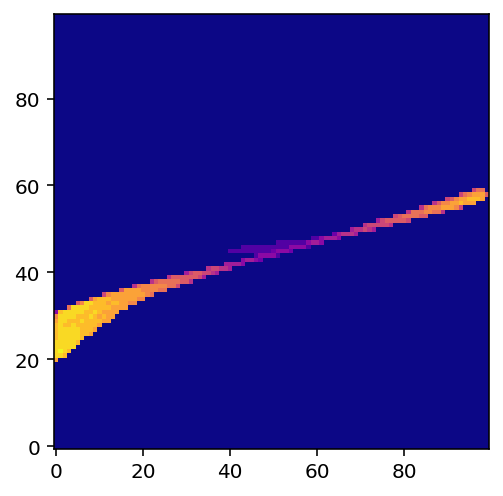

In [ ]:
# Calculates average of all flights together
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

# Flights average
flights_average = np.zeros([100,100,20]) 
for channel in range(20): # iterate channels
  for week in range(week_array.shape[0]): # iterate weeks
    flights_average[:, :, channel] += np.sum(week_array[week, :, :, :, channel], axis=0)

flights_average /= (week_array.shape[0] * week_array.shape[1]) # total_weeks x total_hours
flights_average = np.where(flights_average > 0.01, 1, 0)

for i in range(0, flights_average.shape[-1]):
  print(f'Level {i}: {np.sum(flights_average[:,:,i])}')

flights_flatten_average = flatten_array(flights_average)
plt.imshow(flights_flatten_average, origin='lower', cmap = plt.get_cmap('plasma'))

(100, 100, 20)

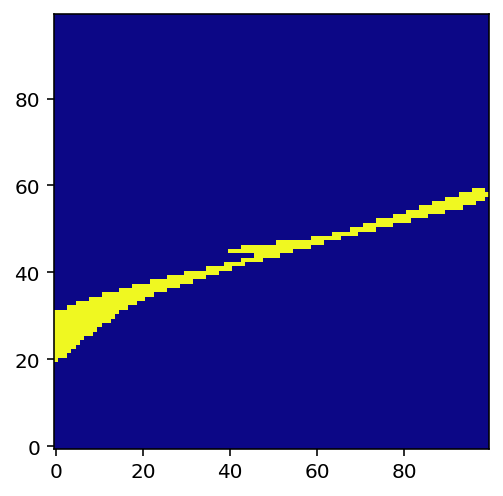

In [ ]:
# Calculates the envelope for all flight levels
flights_envelope = np.where(flights_flatten_average > 0, 1, 0)
stack = []
for i in range(20):
  stack.append(flights_envelope)

flights_envelope = np.array(stack)
flights_envelope = np.moveaxis(flights_envelope, 0, -1)
plt.imshow(flatten_array(flights_envelope), origin='lower', cmap='plasma')
flights_envelope.shape

# Mask Flights Array to Remove Outliers

In [ ]:
from tqdm import tqdm

# Masks all hours in array
masked_week_array = np.empty((week_array.shape[0],week_array.shape[1],100,100,20))
for i in tqdm(range(week_array.shape[0])):
  for j in range(week_array.shape[1]):
    masked_week_array[i,j] = week_array[i,j] * flights_envelope 

100%|██████████| 38/38 [00:21<00:00,  1.77it/s]


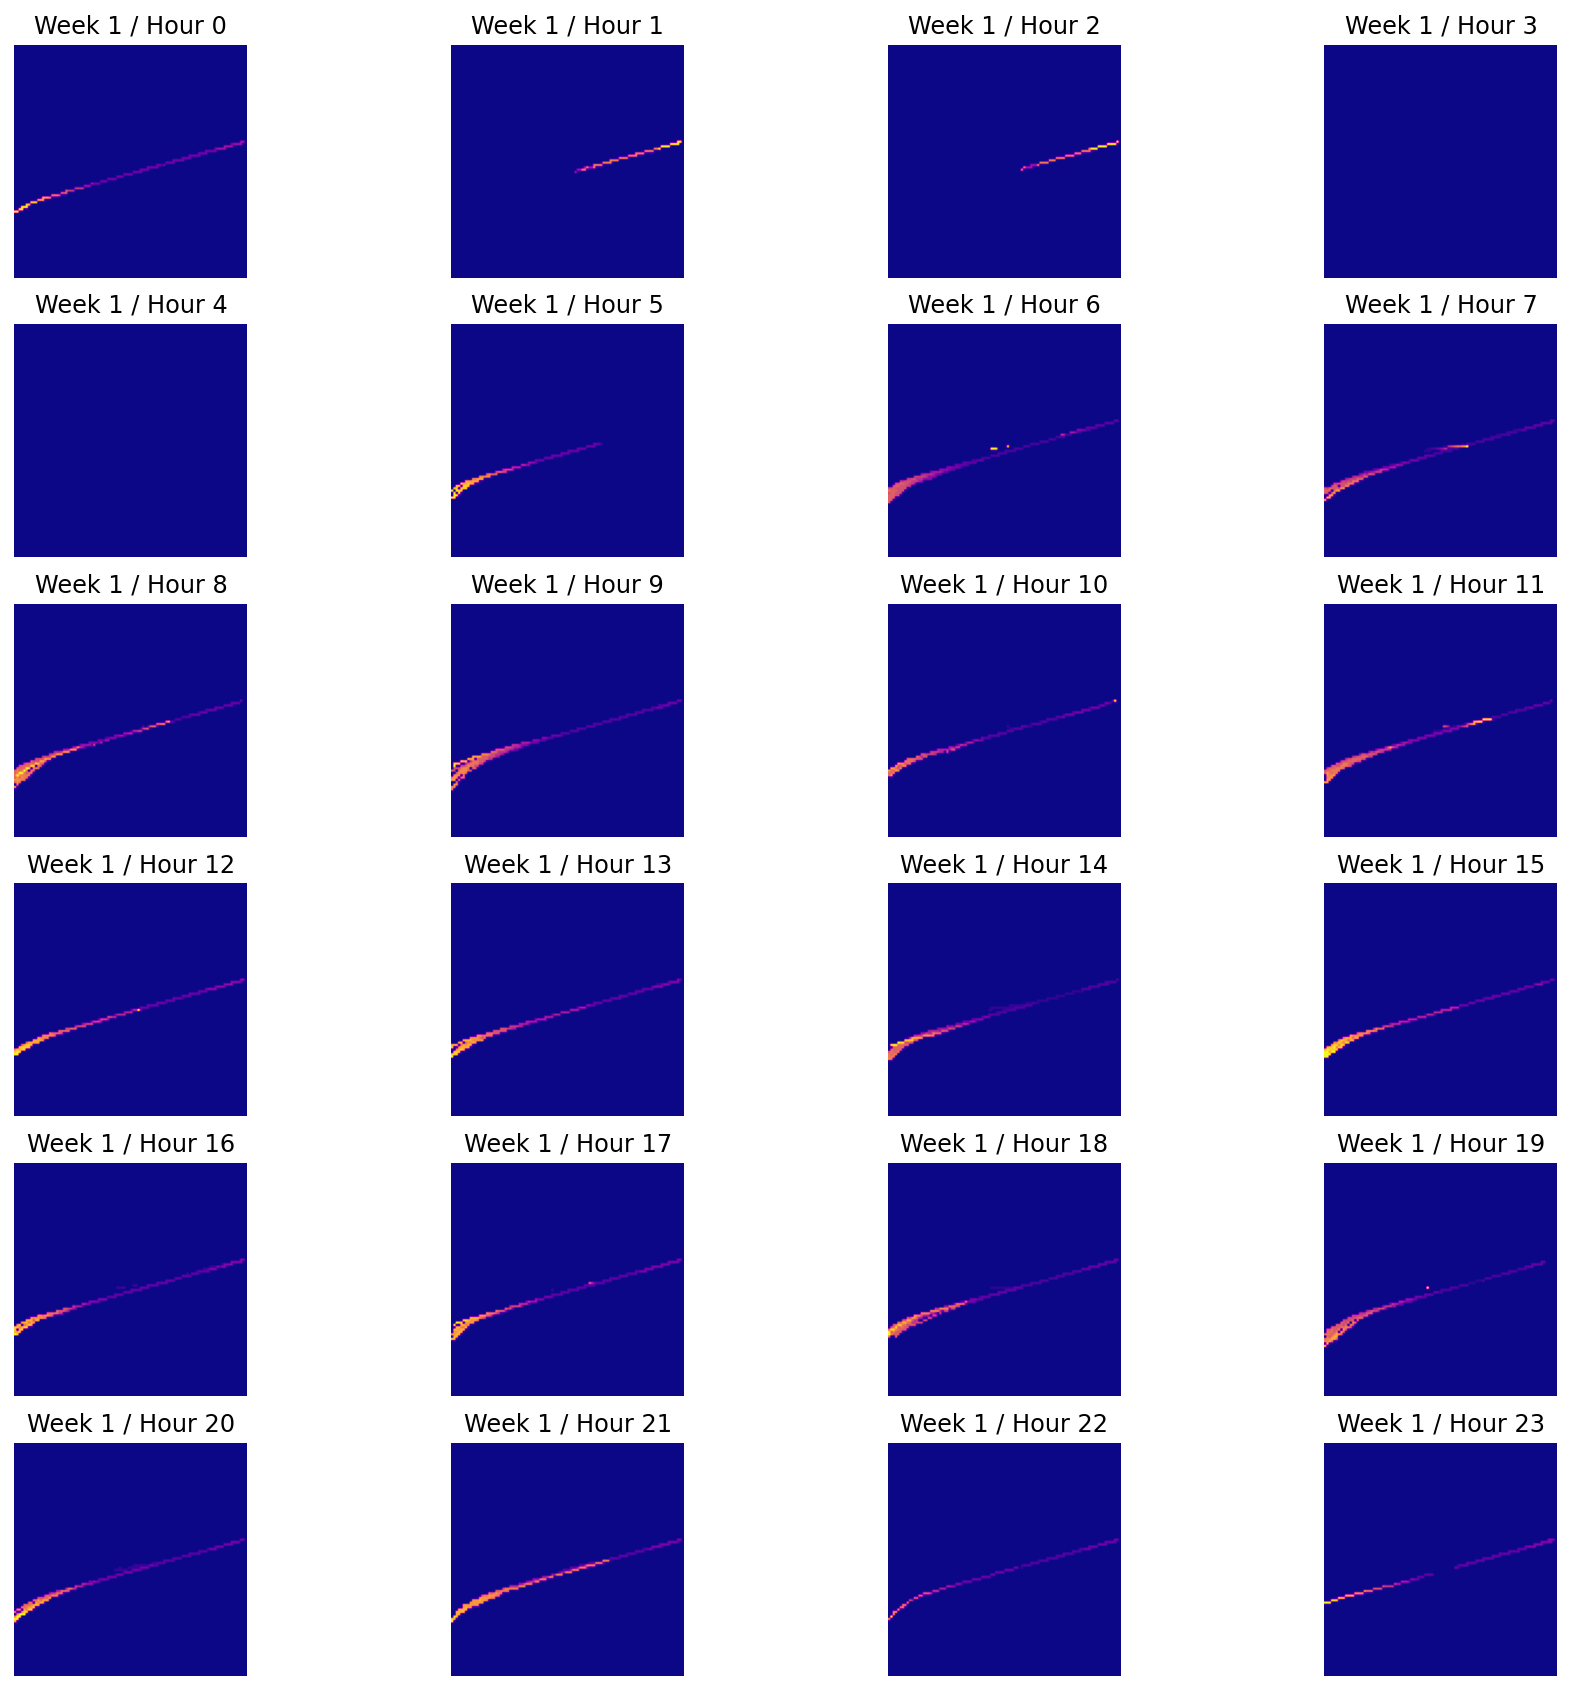

In [ ]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

# Visualization
week = 1 # Week since dataset started
day = 0 # 0 to 6 / Mon to Sun

# Previews a whole day
fig, ax = plt.subplots(6, 4, figsize=(15, 15))
for idx, ax in enumerate(ax.flat):
  plot = ax.imshow(flatten_array(masked_week_array[week, idx + (day * 24)]), origin='lower', cmap = plt.get_cmap('plasma'))
  ax.set_title(f'Week {week} / Hour {idx + (day * 24)}')
  ax.axis("off")

# Save Results

**Save Average Flights Array**

In [ ]:
np.save(f'dataset/00_results/flights_average_{masked_week_array.shape[0]}.npy', flights_average)

**Save Masked Array**

In [ ]:
np.save(f'dataset/00_results/flights_array_masked_{masked_week_array.shape[0]}.npy', masked_week_array)